In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable inline plotting for Jupyter note.
%matplotlib inline


In [3]:
# Create a tensor with 200.
X = torch.linspace(-10, 10, 200).reshape(-1, 1)


In [5]:
# Calculate y using PyTorch operations. 
y=(np.sin(5*(np.pi*X)))/((5*(np.pi*X)))
# Handleing error.
y = torch.where(X == 0, torch.tensor(1.0), torch.sin(5 * torch.pi * X) / (5 * torch.pi * X))


In [7]:
# Function to calculate trainable parameters in a model.
def calculate_parameters(model):
    total_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
    return total_params


In [8]:
#Creating Model
class Model(nn.Module):
    def __init__(self, in_features=1, h1=4, h2=8, out_features=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [9]:
model=Model()
print(model)

Model(
  (fc1): Linear(in_features=1, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)


In [10]:
# Calculate the number of parameters in the model
modelparams = calculate_parameters(model)
print(modelparams)


57


In [26]:
# Calculate the consistency for each layer
lay1_cons = 1 * 4
lay2_cons = 4 * 8
lay3_cons = 8 * 1
tot_mod_cons = lay1_cons + lay2_cons + lay3_cons





In [27]:
crit_loss = nn.CrossEntropyLoss()

In [28]:
# Adam optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [34]:
no_iterations=8
epochs = 30
epoch_num=round(epochs/3)
mod_losses = []
c=0
lay2_weights_tensor = torch.zeros((no_iterations * epoch_num, lay2_cons))
whole_mod_weights_tensor = torch.zeros((no_iterations * epoch_num, tot_mod_cons))
loss_tensor = torch.zeros((no_iterations * epoch_num, 1))
for train in range(no_iterations):
    model=Model()
    crit_loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    for i in range(epochs):
        i+=1
        # feed forward
        y_pred = model.forward(X)
        # compute error
        trn_loss = crit_loss(y_pred, y)
        mod_losses.append(trn_loss)
        
        optim.zero_grad()
        trn_loss.backward()
        optim.step()
        
        # for every 3 epochs, collect weights and loss of the model
        if i % 3 == 0:
            # collect weights of the model
            lay1_weights = torch.reshape(torch.flatten(model.fc1.weight), (1, lay1_cons))
            lay2_weights  = torch.reshape(torch.flatten(model.fc2.weight), (1, lay2_cons))
            lay3_weights  = torch.reshape(torch.flatten(model.fc3.weight), (1, lay3_cons))
            # Combine all layers weights for the whole model
            sum_lay1_lay2 = torch.cat((lay2_weights , lay1_weights), dim=1)
            whole_mod_weights = torch.cat((sum_lay1_lay2, lay3_weights), dim=1)
            # Save weights and loss 
            whole_mod_weights_tensor[c] = whole_mod_weights
            lay2_weights_tensor[c] = lay2_weights
            loss_tensor[c] = trn_loss
            c += 1

In [35]:
import numpy as np

def PcaImplem(input_array, dimensions_to_return):
    m, n = input_array.shape
    
    means_input = np.mean(input_array, axis=0)
    normalized_input = input_array - means_input
    
    covariance_matrix = np.dot(normalized_input.T, normalized_input)
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    pairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(n)]
    pairs.sort(key=lambda x: x[0], reverse=True)
    
    selected_features = np.array([value[1] for value in pairs[:dimensions_to_return]])
    reduced_dimension_data = np.dot(normalized_input, selected_features.T)
    
    return reduced_dimension_data



In [38]:
layer2_reduced = lay2_weights_tensor.detach().cpu().numpy()
whole_model_reduced = whole_mod_weights_tensor.detach().cpu().numpy()
loss_vector = loss_tensor.detach().cpu().numpy()

layer2_reduced = PcaImplem(layer2_reduced, 2)
whole_model_reduced = PcaImplem(whole_model_reduced, 2)



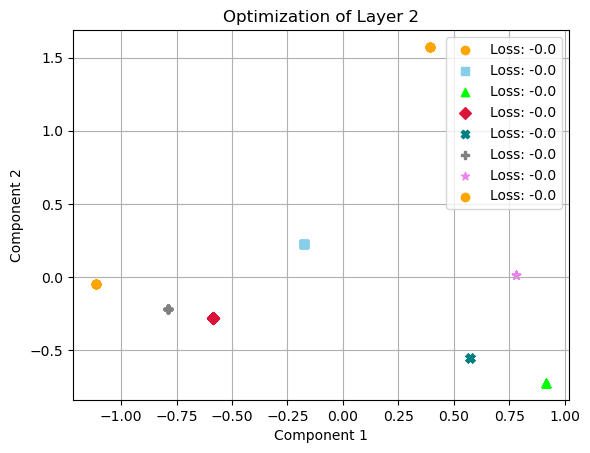

In [46]:
import matplotlib.pyplot as plt

# Plot optimization of Layer 2 of Neural Network.
color_symbols = ['o', 's', '^', 'D', 'X', 'P', '*']
color_names = ["orange", "skyblue", "lime", "crimson", "teal", "gray", "violet"]
counter = 0
color_index = 0

for point in lay2_reduced:
    if (counter % 10) == 0 and counter != 0:
        color_index = (color_index + 1) % len(color_symbols)
        
    plt.scatter(point[0], point[1], color=color_names[color_index], marker=color_symbols[color_index], label=f"Loss: {round(loss_vector[counter][0], 2)}" if counter % 10 == 0 else "")
    counter += 1

plt.title("Optimization of Layer 2")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


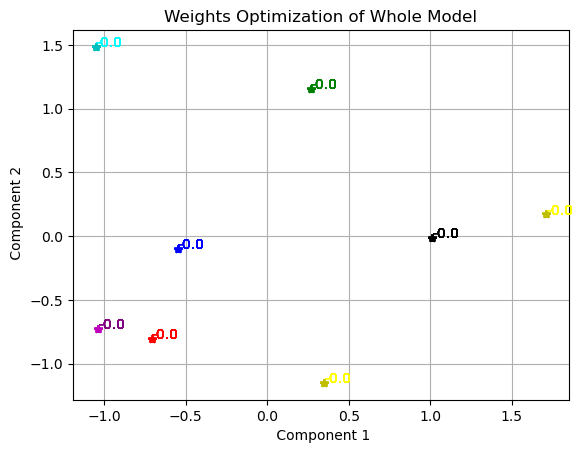

In [45]:
import matplotlib.pyplot as plt

# Define color lists
colour_list = ['y*', 'b*', 'g*', 'r*', 'c*', 'k*', 'm*']
colour_name_list = ["yellow", "blue", "green", "red", "cyan", "black", "purple"]

# Plot optimization of Whole Model of Neural Network
counter = 0
color_index = 0

for point in whole_mod_red:
    if (counter % 10) == 0 and counter != 0:
        color_index = (color_index + 1) % len(colour_list)
        
    plt.plot(point[0], point[1], colour_list[color_index])
    plt.annotate(str(round(loss_vector[counter][0], 2)), (point[0], point[1]), color=colour_name_list[color_index])
    counter += 1

plt.title("Weights Optimization of Whole Model")
plt.xlabel(" Component 1")
plt.ylabel(" Component 2")
plt.grid(True)
plt.show()

